       provider_number  year  report_count
0                10001  2010             1
1                10001  2011             1
2                10001  2012             1
3                10001  2013             1
4                10001  2014             1
...                ...   ...           ...
44639           673063  2016             1
44640           673063  2017             1
44641           673064  2016             1
44642           673064  2017             1
44643           673065  2016             1

[44644 rows x 3 columns]


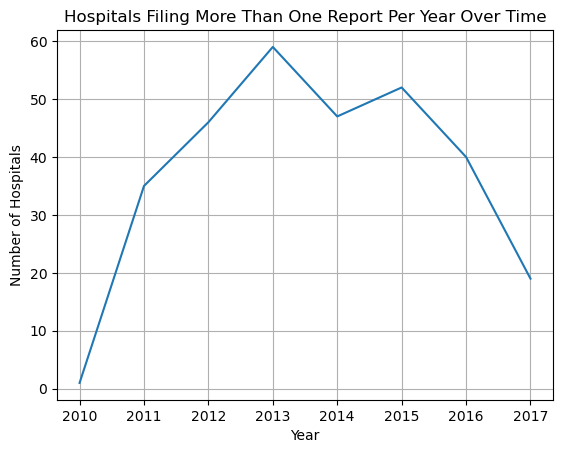

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read in data
hcris_data=pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW2/data/output/HCRIS_Data.csv')


# Convert 'fy_start' to datetime to extract the year
hcris_data['fy_start'] = pd.to_datetime(hcris_data['fy_start'], errors='coerce')
hcris_data['year'] = hcris_data['fy_start'].dt.year

# Count hospitals that filed more than one report in the same year
hospital_counts = hcris_data.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

print(hospital_counts)
# Plot the results
plt.figure()
plt.plot(hospitals_over_time.index, hospitals_over_time.values)
plt.xlabel('Year')
plt.ylabel('Number of Hospitals')
plt.title('Hospitals Filing More Than One Report Per Year Over Time')
plt.grid(True)
plt.show()


In [7]:
# Remove duplicate reports by keeping only the first occurrence per hospital per year
unique_hospitals = hcris_data.drop_duplicates(subset=['provider_number', 'year'])

# Count the number of unique hospital IDs (Medicare provider numbers)
unique_hospital_count = unique_hospitals['provider_number'].nunique()

# Display the result
print("Number of unique hospital IDs:", unique_hospital_count)

Number of unique hospital IDs: 6602


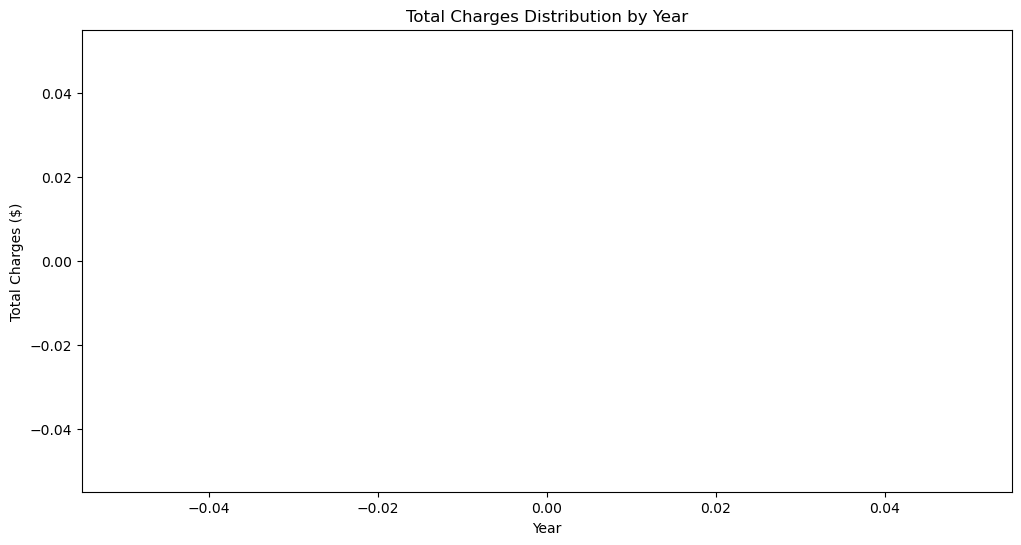

In [11]:
#total charges per year
years = sorted(hcris_data['year'].dropna().unique())
df_tot_charges = [hcris_data[hcris_data['year'] == y]['tot_charges'] for y in years]
# Plot
plt.figure(figsize=(12, 6))
plt.violinplot(df_tot_charges, showmedians=True)
plt.xlabel('Year')
plt.ylabel('Total Charges ($)')
plt.title('Total Charges Distribution by Year')

plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

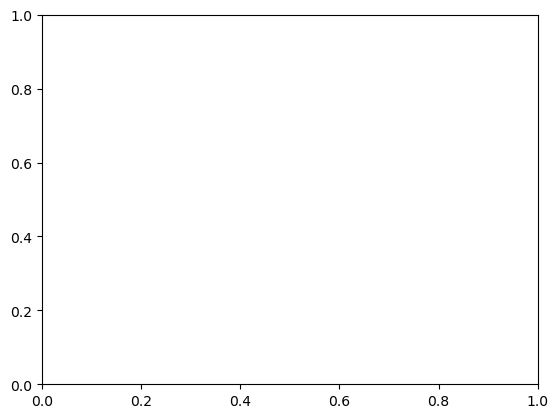

In [ ]:
# Compute estimated price using the given formula
hcris_data['discount_factor'] = 1 - hcris_data['tot_discounts'] / hcris_data['tot_charges']
hcris_data['price_num'] = (hcris_data['ip_charges'] + hcris_data['icu_charges'] + hcris_data['ancillary_charges']) * hcris_data['discount_factor'] - hcris_data['tot_mcare_payment']
hcris_data['price_denom'] = hcris_data['tot_discharges'] - hcris_data['mcare_discharges']
hcris_data['estimated_price'] = hcris_data['price_num'] / hcris_data['price_denom']

# Remove negative and extreme outlier values
# Calculate mean and standard deviation
mean_price = hcris_data['estimated_price'].mean()
std_price = hcris_data['estimated_price'].std()

# Define lower and upper bounds for outlier removal (3 standard deviations from mean)
lower_bound = mean_price - (3 * std_price)
upper_bound = mean_price + (3 * std_price)

# Remove negative values
hcris_data = hcris_data[hcris_data['estimated_price'] > 0]

# Remove outliers
hcris_data = hcris_data[(hcris_data['estimated_price'] >= lower_bound) & (hcris_data['estimated_price'] <= upper_bound)]

estimated_price_df = [hcris_data[hcris_data['year'] == y]['estimated_price'] for y in years]
ep_years = sorted(hcris_data['year'].dropna().unique())

# Plot
plt.figure()
plt.violinplot(estimated_price_df, showmedians=True)
plt.xticks(range(1, len(ep_years) + 1), ep_years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Estimated Price ($)')
plt.title('Estimated Price Distribution by Year')
plt.yscale('log')  # Log scale for better visualization
plt.show()


In [12]:
# Filter data for the year 2012
hcris_2012 = hcris_data[hcris_data['year'] == 2012].copy()

# Define penalty: If the sum of HRRP and HVBP payments is negative, it's a penalty
hcris_2012['penalty'] = (hcris_2012['hrrp_payment'] + hcris_2012['hvbp_payment']) < 0

# Calculate estimated price using the given formula
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['estimated_price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Compute the average price for penalized vs. non-penalized hospitals
avg_price_by_penalty = hcris_2012.groupby('penalty')['estimated_price'].mean()

# Show the results
print(avg_price_by_penalty)

penalty
False   NaN
Name: estimated_price, dtype: float64
